In [1]:
import os

import classically as clcl
import corbeille
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import RidgeClassifierCV
from sklearn.preprocessing import StandardScaler
from sktime.classification.kernel_based import RocketClassifier

import fruits

In [2]:
np.random.seed(62)

In [3]:
PATH_TO_UCR_DATASETS =  "..."

# Table of Contents

Below is a collection of UCR datasets that show strange behavior when using *fruits* as a feature
extractor.

1. [Chinatown](#chinatown)
1. [ChlorineConcentration](#chlorineconcentration)
1. [GesturePebble](#gesturepebblez12)
1. [InsectWingbeatSound](#insectwingbeatsound)
1. [SemgHand...](#semghand)
1. [Yoga](#yoga)


# Chinatown

- Increments are decreasing the accuracy
- more random increments lead to lower accuracy 

In [4]:
data = corbeille.data.load(os.path.join(PATH_TO_UCR_DATASETS, "Chinatown"))
data[0].shape, data[2].shape

((20, 1, 24), (343, 1, 24))

In [5]:
rocket = RocketClassifier(num_kernels=168, rocket_transform="multirocket")
rocket.fit(np.nan_to_num(data[0]), data[1])
rocket.score(np.nan_to_num(data[2]), data[3])

0.9737609329446064

In [6]:
fruit = fruits.Fruit()

fruit.cut()
fruit.add(fruits.ISS(
    fruits.words.alternate_sign([fruits.words.SimpleWord(10*"[1]")]),
    mode=fruits.ISSMode.EXTENDED,
    semiring=fruits.semiring.Arctic(),
))
fruit.add(fruits.sieving.END)

In [7]:
analyser = corbeille.Fruitalyser(fruit, data)
analyser.transform_all(
    postprocess=StandardScaler(),
    save_prepared=True,
    save_iterated=True,
)
analyser.classify()

0.9825072886297376

In [8]:
fruit_inc = fruit.deepcopy()
fruit_inc.add(fruits.preparation.INC)
analyser_inc = corbeille.Fruitalyser(fruit_inc, data)
analyser_inc.transform_all(
    postprocess=StandardScaler(),
    save_prepared=True,
    save_iterated=True,
)
analyser_inc.classify()

0.8775510204081632

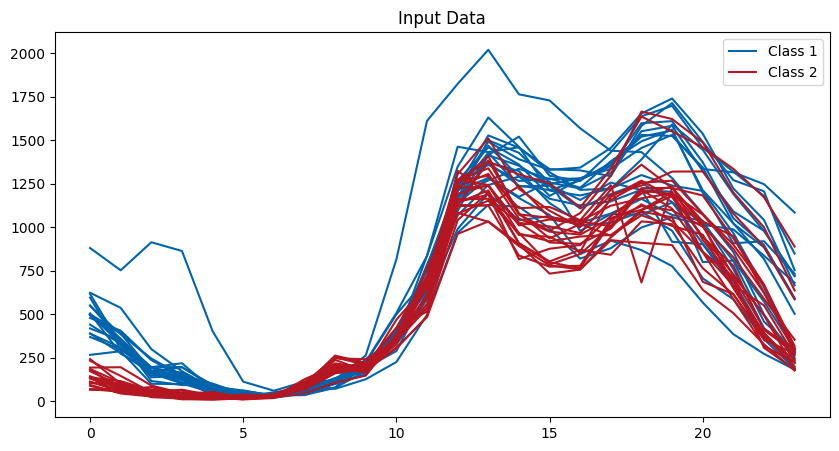

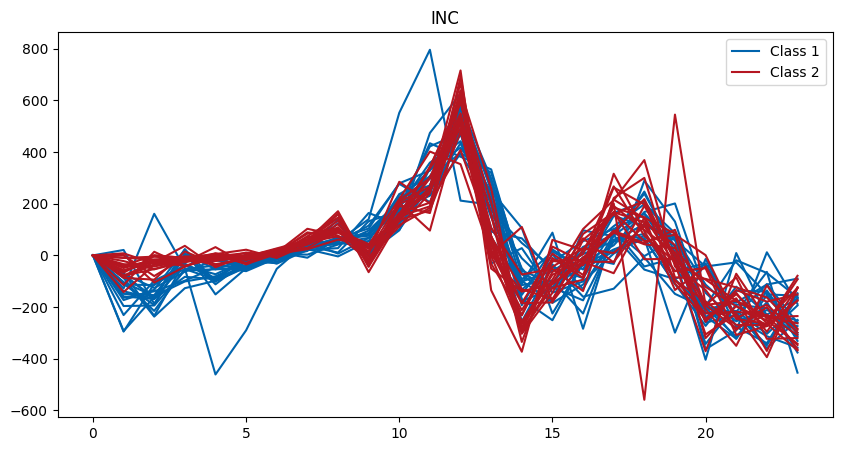

In [9]:
analyser_inc.plot("input", nseries=20)
analyser_inc.plot("prepared", nseries=20)
plt.show()

# ChlorineConcentration

- wrongly labeled dataset leads to strange topological feature structures
- the effect is shown below on the dataset restricted to 2 classes (instead of 3)
- the effect is shown below for the END sieve, however, also other sieves give nice pictures

In [10]:
data = corbeille.data.load(
    os.path.join(PATH_TO_UCR_DATASETS, "ChlorineConcentration")
)
xtrain = data[0][data[1] != 1]
ytrain = data[1][data[1] != 1]
xtest = data[2][data[3] != 1]
ytest = data[3][data[3] != 1]
data_restricted = (xtrain, ytrain, xtest, ytest)

In [11]:
fruit = fruits.Fruit()

fruit.cut()
fruit.add(fruits.ISS(
    fruits.words.of_weight(4, 1),
    mode=fruits.ISSMode.EXTENDED,
    semiring=fruits.semiring.Reals(),
))
fruit.add(fruits.sieving.END)
fruit.nfeatures()

15

In [12]:
analyser = corbeille.Fruitalyser(fruit, data_restricted)
analyser.transform_all(
    postprocess=None,#StandardScaler(),
    save_prepared=True,
    save_iterated=True,
)
analyser.classify()

0.6922816519972919

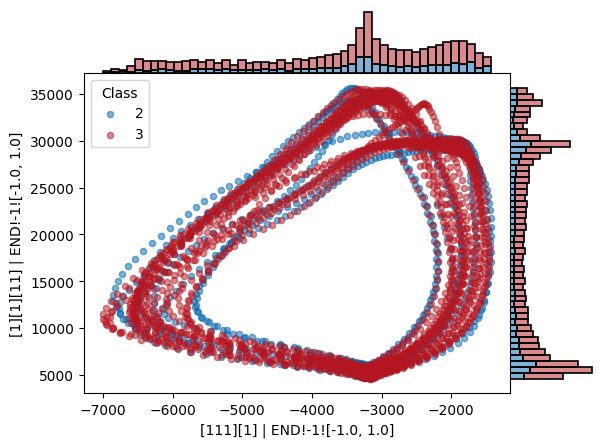

In [13]:
fig, ax, _, _ = analyser.scatter_features(2, 11, s=20)
fig.get_children()[-1].remove()
ax.legend(title="Class")
plt.show()

# GesturePebbleZ1/2

- 32% accuracy difference when replacing NaNs by last value observed instead of 0

In [14]:
data_nan_zero = corbeille.data.load(
    os.path.join(PATH_TO_UCR_DATASETS, "GesturePebbleZ2"),
    keep_nan=True,
)
data_nan_tw = corbeille.data.load(
    os.path.join(PATH_TO_UCR_DATASETS, "GesturePebbleZ2"),
    keep_nan=False,
)

In [15]:
fruit = fruits.Fruit()

fruit.cut()
fruit.add(fruits.ISS(
    fruits.words.of_weight(4, 1),
    mode=fruits.ISSMode.EXTENDED,
    semiring=fruits.semiring.Reals(),
    weighting=fruits.iss.weighting.Indices(),
))
fruit.add(fruits.sieving.END)
fruit.nfeatures()

15

In [16]:
analyser_nan_zero = corbeille.Fruitalyser(fruit, data_nan_zero)
analyser_nan_zero.transform_all(
    postprocess=StandardScaler(),
    save_prepared=True,
    save_iterated=True,
)
analyser_nan_zero.classify()

0.15822784810126583

In [17]:
analyser_nan_tw = corbeille.Fruitalyser(fruit, data_nan_tw)
analyser_nan_tw.transform_all(
    postprocess=StandardScaler(),
    save_prepared=True,
    save_iterated=True,
)
analyser_nan_tw.classify()

0.47468354430379744

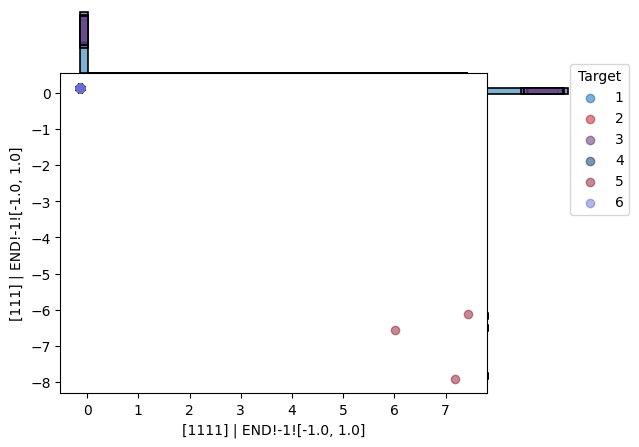

In [18]:
analyser_nan_zero.scatter_features(0, 1)
plt.show()

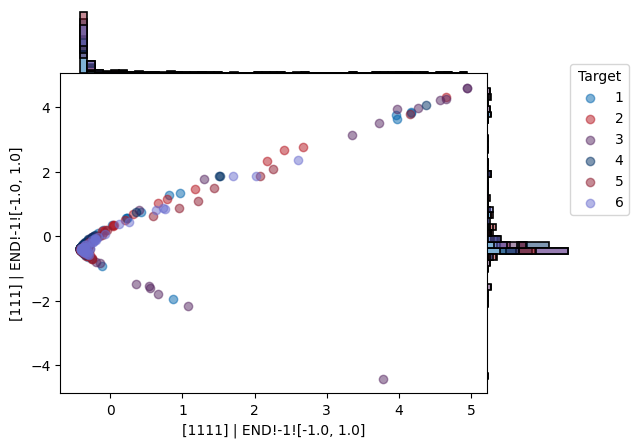

In [19]:
analyser_nan_tw.scatter_features(0, 1)
plt.show()

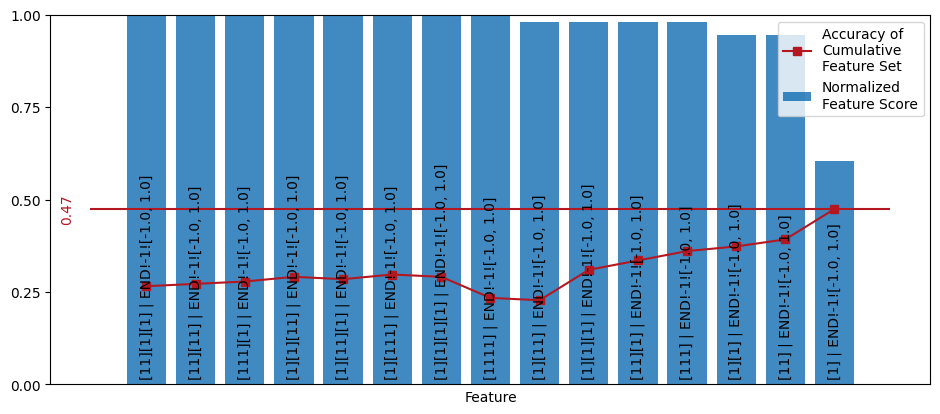

In [20]:
data = (
    analyser_nan_tw.features(source="train").to_numpy(),
    data_nan_tw[1],
    analyser_nan_tw.features(source="test").to_numpy(),
    data_nan_tw[3],
)

fig, ax = clcl.plot_feature_score(
    data,
    restrict=15,
    labels=[fruit.label(i) for i in range(fruit.nfeatures())],
    classifier=RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
)
fig.subplots_adjust(right=1.5)
plt.show()

# InsectWingbeatSound

- interesting performance boost of multirocket: `num_kernels=167` vs `num_kernels=168`
  (672 vs 1344 features)
- I think this is the number of features used by multirocket and because it uses a fixed set
of at least 84 kernels per feature and as 168/84=2, it can now use another feature map

In [21]:
data = corbeille.data.load(
    os.path.join(PATH_TO_UCR_DATASETS, "InsectWingbeatSound"),
)

In [22]:
rocket = RocketClassifier(num_kernels=167, rocket_transform="multirocket")
rocket.fit(np.nan_to_num(data[0]), data[1])
rocket.score(np.nan_to_num(data[2]), data[3])

0.4994949494949495

In [23]:
rocket = RocketClassifier(num_kernels=168, rocket_transform="multirocket")
rocket.fit(np.nan_to_num(data[0]), data[1])
rocket.score(np.nan_to_num(data[2]), data[3])

0.6722222222222223

# Yoga

- NPI Preparateur is fundamentally important for a good accuracy (esp. together with `[1111]`)

In [24]:
data = corbeille.data.load(os.path.join(PATH_TO_UCR_DATASETS, "Yoga"))

In [25]:
fruit_nonpi = fruits.Fruit()

fruit_nonpi.cut()
fruit_nonpi.add(fruits.preparation.NEW(fruits.preparation.INC()))
fruit_nonpi.add(fruits.ISS(
    fruits.words.of_weight(4, 2),
    mode=fruits.ISSMode.EXTENDED,
    semiring=fruits.semiring.Reals(),
))
fruit_nonpi.add(fruits.sieving.END)
fruit_nonpi.nfeatures()

115

In [26]:
fruit_npi = fruits.Fruit()

fruit_npi.cut()
fruit_npi.add(fruits.preparation.INC)
fruit_npi.add(fruits.ISS(
    [fruits.words.SimpleWord("[1111]")],
    # fruits.words.of_weight(4, 1),
    # mode=fruits.ISSMode.EXTENDED,
    semiring=fruits.semiring.Reals(),
    # weighting=fruits.iss.Weighting(use_sum=None),
))
fruit_npi.add(fruits.sieving.NPI)
fruit_npi.nfeatures()

1

In [27]:
analyser_nonpi = corbeille.Fruitalyser(fruit_nonpi, data)
analyser_nonpi.transform_all(
    postprocess=StandardScaler(),
    save_prepared=True,
    save_iterated=True,
)
analyser_nonpi.classify()

0.701

In [28]:
analyser_npi = corbeille.Fruitalyser(fruit_npi, data)
analyser_npi.transform_all(
    postprocess=StandardScaler(),
    save_prepared=True,
    save_iterated=True,
)
analyser_npi.classify()

0.8536666666666667

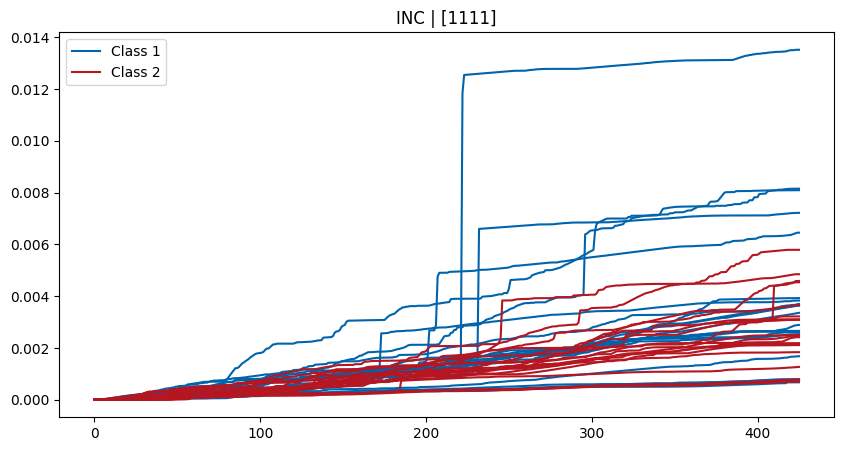

In [29]:
analyser_npi.plot("iterated sums", index=0, nseries=20)
plt.show()

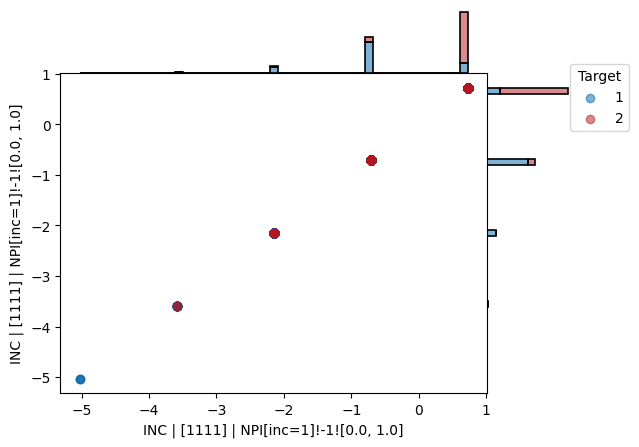

In [30]:
analyser_npi.scatter_features(0, 0)
plt.show()

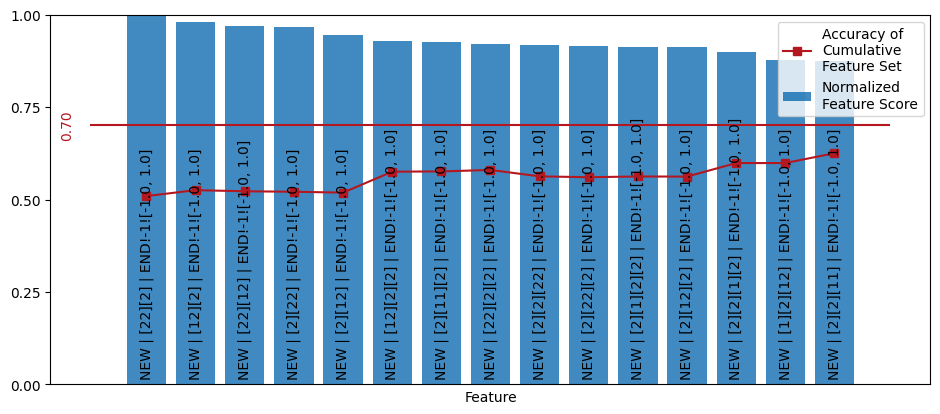

In [31]:
data_ = (
    analyser_nonpi.features(source="train").to_numpy(),
    data[1],
    analyser_nonpi.features(source="test").to_numpy(),
    data[3],
)

fig, ax = clcl.plot_feature_score(
    data_,
    restrict=15,
    labels=[fruit_nonpi.label(i) for i in range(fruit_nonpi.nfeatures())],
    classifier=RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
)
fig.subplots_adjust(right=1.5)
plt.show()